Total points for this HW: 10

Make sure that you run all your codes and that all results are printed.

Please note: Copying and pasting other people's work is absolutely prohibited. Any such cases will be reported to CUSP's education team and severely punished. Discussion is encouraged, and feel free to exchange ideas with your classmates, but please write your own code and do your own work.

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

## Question 1 (15%) 

### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

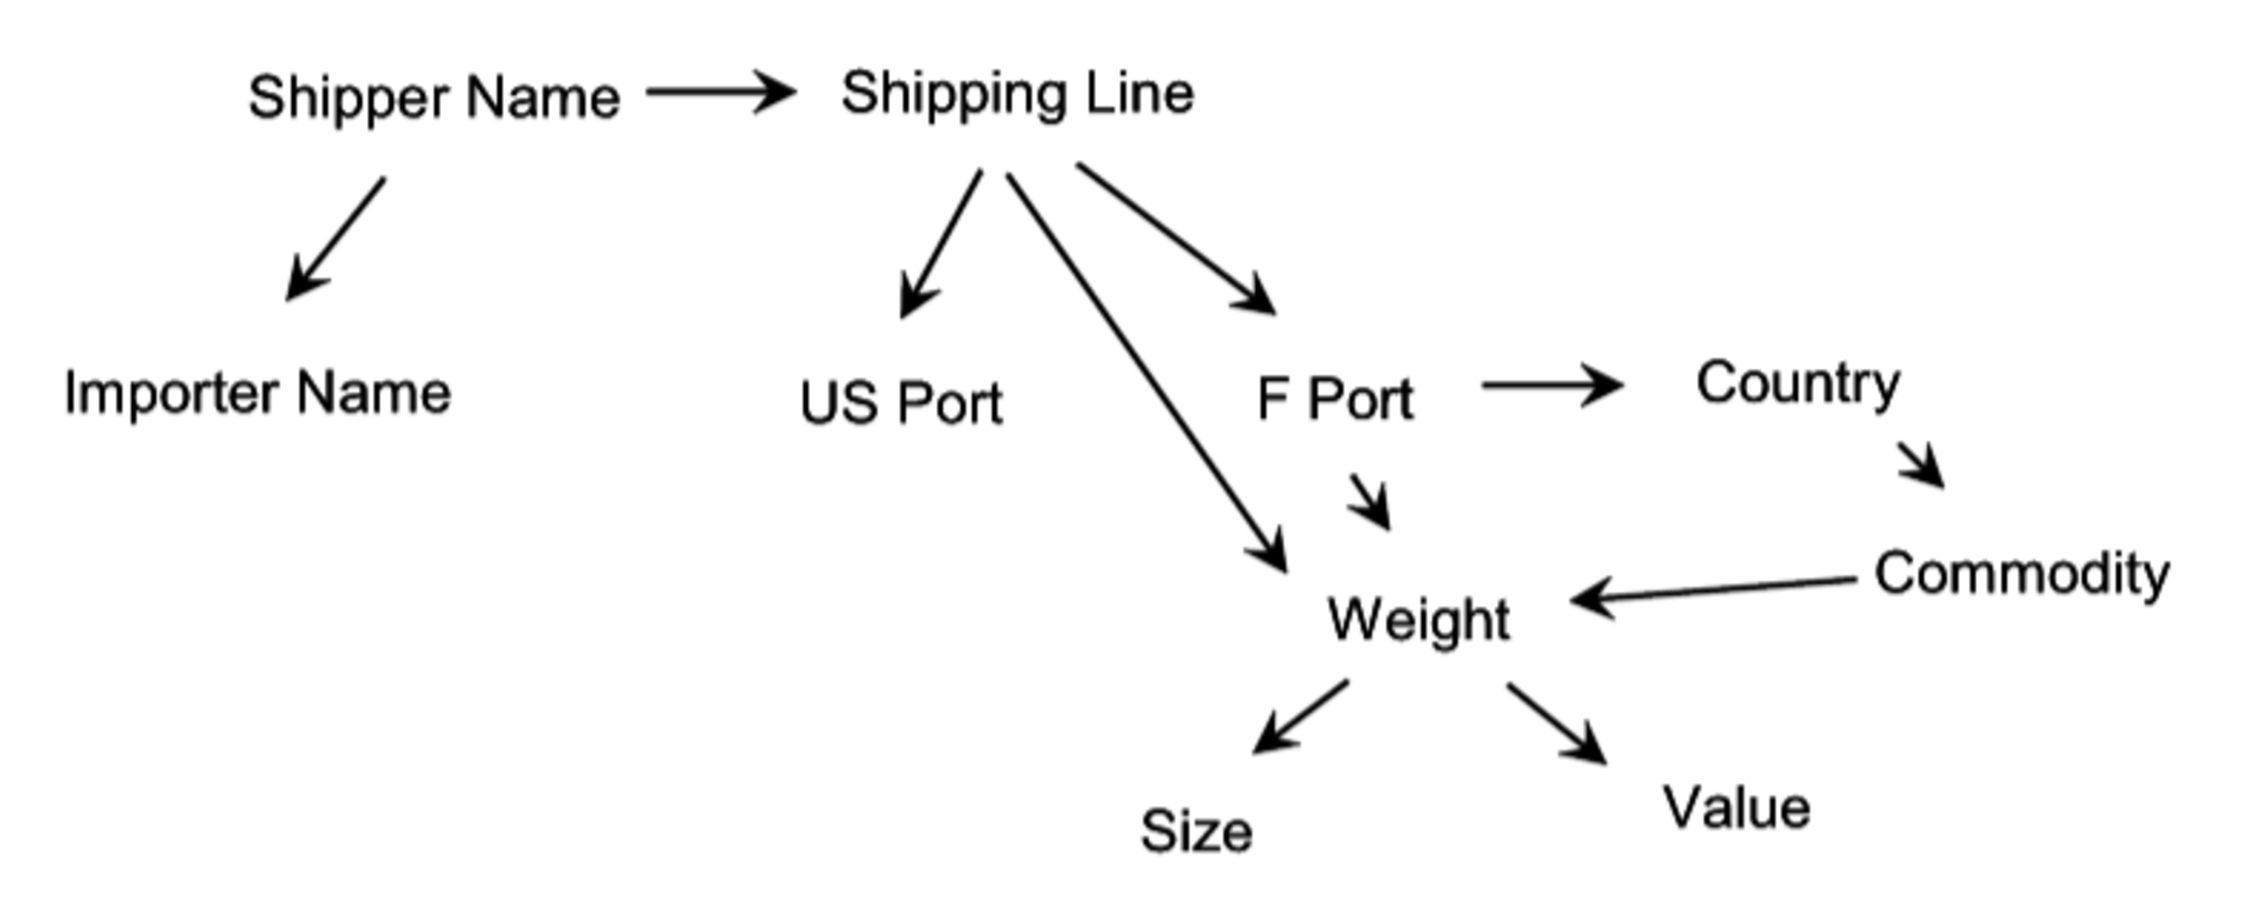

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Shipper Name, Value | F Port)?  Dependent

CI (Shipper Name, Value | Shipping Line)?  Independent

CI (Foreign Port, Commodity | Country)? Independent (or Dependent in some cases, based on the explanations)

CI (Foreign Port, Commodity | County, Weight)? Dependent

2) Now consider a smaller dataset with only four discrete attributes (Shipping Line, US Port, Foreign Port, Weight), and the following conditional probability distributions:

Shipping Line: CSCO (80%), ASCO (20%)

Foreign Port | Shipping Line = CSCO: Yokohama (40%), Vancouver (60%)

Foreign Port | Shipping Line = ASCO: Vancouver (100%)

US Port | Shipping Line = ASCO: Seattle (100%)

US Port | Shipping Line = CSCO: Seattle (20%), Los Angeles (80%)

Weight | Shipping Line = CSCO, Foreign Port = Vancouver: Light (30%), Medium (20%), Heavy (50%)

Weight | Shipping Line = CSCO, Foreign Port = Yokohama: Light (10%), Medium (60%), Heavy (30%)

Weight | Shipping Line = ASCO, Foreign Port = Vancouver: Light (15%), Medium (15%), Heavy (70%)

Which of the following packages is most anomalous?

a) A light package shipped from Vancouver to Seattle by ASCO

b) A medium package shipped from Vancouver to Seattle by CSCO

c) A heavy package shipped from Yokohama to Los Angeles by CSCO

To answer this question, compute the likelihood of each package given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

(Your answers here, including all calculations)

a) Likelihood = P(ASCO) P(Vancouver|ASCO) P(Seattle|ASCO) P(Light|ASCO,Vancouver) = (0.2)(1)(1)(0.15) = 0.03 [2 pts]

b) Likelihood = P(CSCO) P(Vancouver|CSCO) P(Seattle|CSCO) P(Medium|CSCO,Vancouver) = (0.8)(0.6)(0.2)(0.2) = 0.0192 [2 pts]

c) Likelihood = P(CSCO) P(Yokohama|CSCO)  P(L.A. | CSCO)  P(Heavy|CSCO,Yokohama)  = (0.8)(0.4)(0.8)(0.3) = 0.0768 [2 pts]

Package b is most anomalous (lowest likelihood) [3 pts]

## Question 2. Bayesian Network Learning (35%)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [3]:
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

,A,B,C,D,E,F
0,1,0,0,0,1,1
1,0,0,0,1,0,1
2,1,1,0,1,1,1
3,1,0,0,1,1,1
4,2,0,1,0,1,1


a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [4]:
from pgmpy.estimators import HillClimbSearch,BicScore,BayesianEstimator
from pgmpy.models import BayesianNetwork
hc = HillClimbSearch(train)
best_model = BayesianNetwork(hc.estimate(scoring_method='BicScore').edges()) # convert DAG to BayesianModel
print(best_model.edges())

best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')
for cpd in best_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
    
predicted_test = best_model.predict(test.loc[:,["B","D","E"]]) # C and F are independent of A
print("Out of sample:",(test.loc[:,"A"].reset_index(drop=True)==predicted_test["A"]).mean())


[('B', 'A'), ('D', 'A'), ('E', 'A')]


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


CPD of B:
+------+--------+
| B(0) | 0.5015 |
+------+--------+
| B(1) | 0.4985 |
+------+--------+
CPD of A:
+------+----------------------+-----+----------------------+
| B    | B(0)                 | ... | B(1)                 |
+------+----------------------+-----+----------------------+
| D    | D(0)                 | ... | D(1)                 |
+------+----------------------+-----+----------------------+
| E    | E(0)                 | ... | E(1)                 |
+------+----------------------+-----+----------------------+
| A(0) | 0.4965893587994543   | ... | 0.001349527665317139 |
+------+----------------------+-----+----------------------+
| A(1) | 0.5006821282401092   | ... | 0.5033738191632928   |
+------+----------------------+-----+----------------------+
| A(2) | 0.001364256480218281 | ... | 0.4939271255060729   |
+------+----------------------+-----+----------------------+
| A(3) | 0.001364256480218281 | ... | 0.001349527665317139 |
+------+----------------------+-----


Out of sample: 0.5645


### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (5 pts).

c) Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (5 pts)  

d) Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (5 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (5 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [5]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

,crime_type,Category,day_Sun,day_Mon,day_Tue,day_Wed,day_Thu,day_Fri,day_Sat,hour_0,...,community_area_68,community_area_69,community_area_70,community_area_71,community_area_72,community_area_73,community_area_74,community_area_75,community_area_76,community_area_77
0,ARSON: BY FIRE,P1P,0.138810,0.135977,0.155807,0.121813,0.130312,0.147309,0.169972,0.073654,...,0.019830,0.016997,0.019830,0.022663,0.005666,0.000000,0.002833,0.005666,0.000000,0.002833
1,ASSAULT: AGG PO HANDS NO/MIN INJURY,P2,0.151852,0.118519,0.162963,0.122222,0.129630,0.129630,0.185185,0.055556,...,0.037037,0.048148,0.018519,0.025926,0.003704,0.003704,0.003704,0.011111,0.011111,0.007407
2,ASSAULT: AGGRAVATED: HANDGUN,P1V,0.149912,0.139405,0.141506,0.131349,0.136953,0.133100,0.167776,0.040630,...,0.035377,0.031524,0.013310,0.042732,0.002102,0.017863,0.000000,0.012259,0.002102,0.003152
3,ASSAULT: AGGRAVATED: OTHER DANG WEAPON,P1V,0.125000,0.139000,0.148000,0.153000,0.133000,0.142000,0.160000,0.034000,...,0.028000,0.030000,0.014000,0.037000,0.003000,0.010000,0.002000,0.002000,0.003000,0.006000
4,ASSAULT: AGGRAVATED: OTHER FIREARM,P1V,0.156863,0.107843,0.166667,0.117647,0.147059,0.117647,0.186275,0.009804,...,0.029412,0.019608,0.009804,0.019608,0.000000,0.000000,0.000000,0.009804,0.000000,0.000000


In [6]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

,Community Area Number,COMMUNITY AREA NAME,centroid_x,centroid_y,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,PERCENT OF HOUSING UNITS VACANT,NUM_CRIMES_2016
0,1,Rogers Park,1164399.219,1947666.815,7.7,23.6,8.7,18.2,27.5,23939,11.870556,3420
1,2,West Ridge,1158307.200,1943243.722,7.8,17.2,8.8,20.8,38.5,23040,9.870385,3068
2,3,Uptown,1168228.082,1930980.022,3.8,24.0,8.9,11.8,22.2,35787,8.672137,3330
3,4,Lincoln Square,1159618.804,1933105.743,3.4,10.9,8.2,13.4,25.5,37524,8.600422,1859
4,5,North Center,1161104.228,1924056.010,0.3,7.5,5.2,4.5,26.2,57123,10.100636,1280


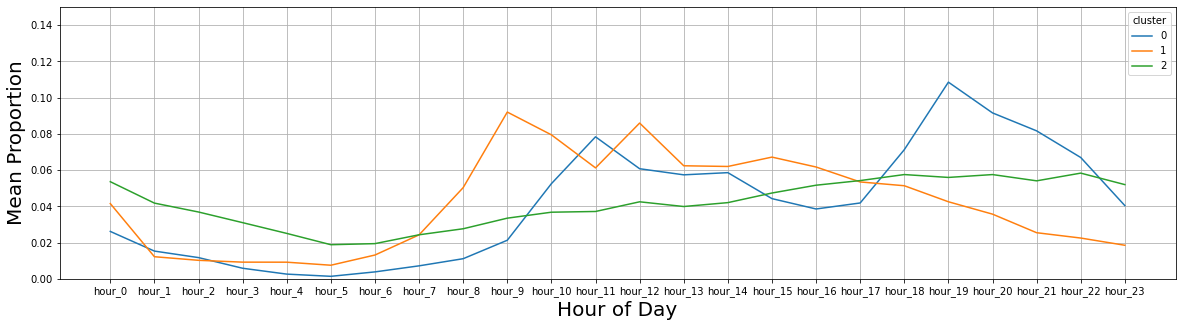

In [7]:
# part a
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X3_hour = data3.iloc[:,9:33]
X3_hour.head()

km = KMeans(random_state=1,n_clusters=3)
cl = km.fit(X3_hour)
label3_hour = cl.labels_
res3_hour = X3_hour.copy()
res3_hour['cluster'] = label3_hour
plot3_hour = res3_hour.groupby('cluster').mean().transpose()

fig, ax = plt.subplots(figsize=(20,5))
plot3_hour.plot(ax=ax, grid=True, xticks=range(24), ylim=(0,0.15))
ax.set_xlabel('Hour of Day', fontsize=20)
ax.set_ylabel('Mean Proportion', fontsize=20)
plt.show()

In [8]:
for i in range(3):
    print(np.mean(1.*(label3_hour==i)))

0.18487394957983194
0.23529411764705882
0.5798319327731093


Part b:

Cluster 0, describing 44.5% of crime types, peaks around 7pm.  Cluster 1, describing 11% of crime types, is peaked in the morning and at lunchtime.   Cluster 2, describing 44.5% of crimes, peaks around 10pm.  (Results may vary somewhat depending on KMeans' random state.) 

In [9]:
data3['cluster']=cl.labels_

In [10]:
# part c

for i in range(3):
    print(data3[data3['cluster']==i].iloc[:,0])

39           DECEPTIVE PRACTICE: COUNTERFEITING DOCUMENT
48                                   GAMBLING: GAME/DICE
50     INTERFERENCE WITH PUBLIC OFFICER: OBSTRUCTING ...
57             NARCOTICS: MANU/DEL:CANNABIS 10GM OR LESS
58              NARCOTICS: MANU/DEL:CANNABIS OVER 10 GMS
59               NARCOTICS: MANU/DELIVER: HEROIN (WHITE)
60                         NARCOTICS: MANU/DELIVER:CRACK
62               NARCOTICS: POSS: CANNABIS 30GMS OR LESS
63             NARCOTICS: POSS: CANNABIS MORE THAN 30GMS
65                                NARCOTICS: POSS: CRACK
66                        NARCOTICS: POSS: HEROIN(WHITE)
67                                  NARCOTICS: POSS: PCP
68                      NARCOTICS: POSS: SYNTHETIC DRUGS
69               NARCOTICS: POSSESSION OF DRUG EQUIPMENT
70             NARCOTICS: SOLICIT NARCOTICS ON PUBLICWAY
77      OTHER OFFENSE: GUN OFFENDER: ANNUAL REGISTRATION
78         OTHER OFFENSE: GUN OFFENDER: DUTY TO REGISTER
81                      OTHER O

Cluster 0 has most of the "theft" and "narcotics" crimes.  Cluster 1 has most of the "deceptive practice" crimes; cluster 2 has most of the serious violent crimes like battery and robbery.

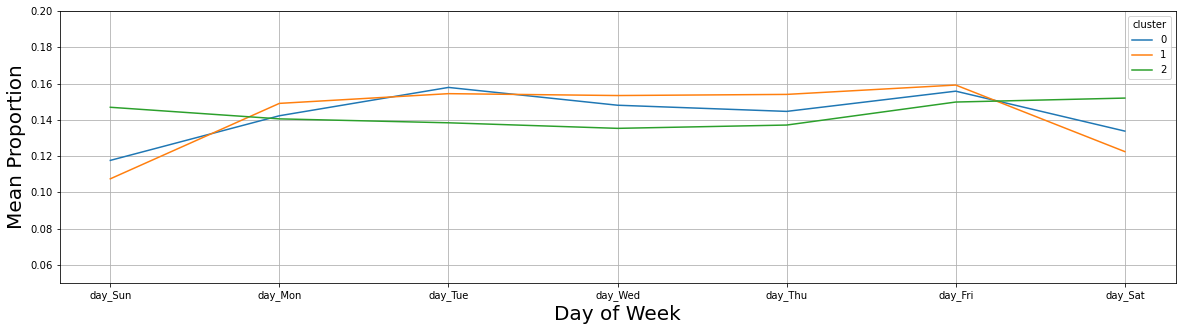

In [11]:
# part d

plot3_dow = data3.groupby('cluster').mean().loc[:,"day_Sun":"day_Sat"].transpose()
fig, ax = plt.subplots(figsize=(20,5))
plot3_dow.plot(ax=ax, grid=True, xticks=range(7), ylim=(0.05,0.2))
ax.set_xlabel('Day of Week', fontsize=20)
ax.set_ylabel('Mean Proportion', fontsize=20)
plt.show()

Clusters 0 and 2 are relatively constant during the week, while cluster 1 is substantially lower on weekends.

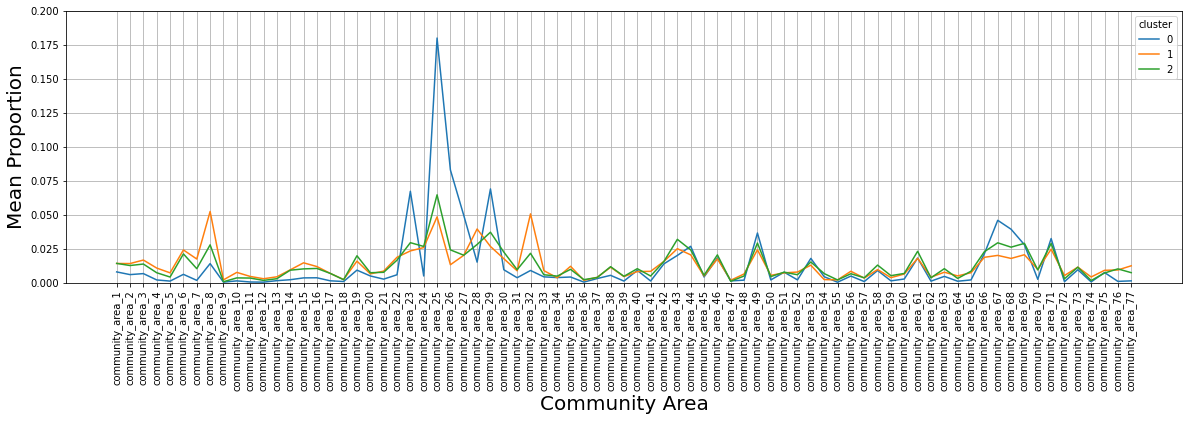

In [14]:
plot3_area = data3.groupby('cluster').mean().loc[:,"community_area_1":"community_area_77"].transpose()
fig, ax = plt.subplots(figsize=(20,5))
plot3_area.plot(ax=ax, grid=True, xticks=range(77), ylim=(0,0.2))
ax.set_xlabel('Community Area', fontsize=20)
ax.set_ylabel('Mean Proportion', fontsize=20)
plt.xticks(rotation=90)
plt.show()

In [15]:
print(data4.iloc[22:29,:])
print(data4.iloc[7,:])
print(data4.iloc[31,:])

    Community Area Number COMMUNITY AREA NAME   centroid_x   centroid_y  \
22                     23       Humboldt park  1151216.159  1906926.141   
23                     24           West Town  1163041.478  1907678.393   
24                     25              Austin  1140839.462  1903174.321   
25                     26  West Garfield Park  1148754.852  1898785.758   
26                     27  East Garfield Park  1155086.641  1898653.301   
27                     28      Near West Side  1167030.371  1898359.955   
28                     29      North Lawndale  1152306.328  1892568.863   

    PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
22                        14.8                              33.9   
23                         2.3                              14.7   
24                         6.3                              28.6   
25                         9.4                              41.7   
26                         8.2                             

We see big spikes in all clusters in the poverty-stricken, high-unemployment districts on Chicago's West Side (23,25-27,29).  The downtown area (Loop and Near North Side) are wealthy areas that are relatively high in cluster 1 (including deceptive practice).

In [16]:
# part f

for i in range(3):
    print(data3[data3['cluster']==i].iloc[:, 1].value_counts())

P2    22
Name: Category, dtype: int64
P2     24
P1P     4
Name: Category, dtype: int64
P2     34
P1V    24
P1P    11
Name: Category, dtype: int64


We see that all the serious (part 1) violent crimes are mapped into cluster 2; cluster 0 gets most of the serious property crimes; and cluster 1 is all less serious (part 2) crimes.

In [17]:
# part g

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.mixture import GaussianMixture
## columns 2:9 in data3 is day_Sun .. day_Sat
X3_day = data3.iloc[:,2:9]
range_n_clusters = range(2,9)

#### Kmeans

print("Running k-means:")
for n_clusters in range_n_clusters:
    silhouette = []
    for i in range(100):
        km = KMeans(random_state=i*i, n_clusters=n_clusters)
        cluster_labels = km.fit(X3_day).labels_
        silhouette.append(silhouette_score(X3_day, cluster_labels))
    silhouette_avg = np.mean(silhouette)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

# Choose n_clusters = 5 or 2

print("For 5 clusters:")
km_g_n = 5
km_g = KMeans(random_state=123, n_clusters=km_g_n)
km_g_labels = km_g.fit(X3_day).labels_
for i in range(km_g_n):
    print('Number of elements in cluster {} : {}'.format(i,np.sum(km_g_labels==i)))
    if (np.sum(km_g_labels==i) < 30):
        print(data3[km_g_labels==i].iloc[:,0])
    
print("For 2 clusters:")
km_g_n = 2
km_g = KMeans(random_state=123, n_clusters=km_g_n)
km_g_labels = km_g.fit(X3_day).labels_
for i in range(km_g_n):
    print('Number of elements in cluster {} : {}'.format(i,np.sum(km_g_labels==i)))
    if (np.sum(km_g_labels==i) < 30):
        print(data3[km_g_labels==i].iloc[:,0])

#### Gaussian mixture models

print("Running Gaussian mixture models:")
for n_clusters in range_n_clusters:
    silhouette = []
    for i in range(100):
        gm = GaussianMixture(random_state=i*i, n_components=n_clusters)
        cluster_labels = gm.fit(X3_day).predict(X3_day)
        silhouette.append(silhouette_score(X3_day, cluster_labels))
    silhouette_avg = np.mean(silhouette)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

# Choose n_clusters = 2

print("For 2 clusters:")
gm_g_n = 2
gm_g = GaussianMixture(random_state=123, n_components=gm_g_n)
gm_g_labels = gm_g.fit(X3_day).predict(X3_day)
for i in range(gm_g_n):
    print('Number of elements in cluster {} : {}'.format(i,np.sum(gm_g_labels==i)))
    if (np.sum(gm_g_labels==i) < 30):
        print(data3[gm_g_labels==i].iloc[:,0])

####  Bottom-up hierarchical clustering with "single link" distance metric

print("Running hierarchical single linkage:")
hc_single = linkage(X3_day, 'single')
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(hc_single, n_clusters, criterion='maxclust')  
    silhouette_avg = silhouette_score(X3_day, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

# Choose n_clusters = 2

print("For 2 clusters:")
hc_s_n = 2
hc_s_labels = fcluster(hc_single, hc_s_n, criterion='maxclust')
for i in range(1,hc_s_n+1):
    print('Number of elements in cluster {} : {}'.format(i,np.sum(hc_s_labels==i)))
    if (np.sum(hc_s_labels==i) < 30):
        print(data3[hc_s_labels==i].iloc[:,0])

#### Bottom-up hierarchical clustering with "complete link" distance metric

print("Running hierarchical complete linkage:")
hc_complex = linkage(X3_day, 'complete')
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(hc_complex, n_clusters, criterion='maxclust')  
    silhouette_avg = silhouette_score(X3_day, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

# Choose n_clusters = 2

print("For 2 clusters:")
hc_c_n = 2
hc_c_labels = fcluster(hc_complex, hc_c_n, criterion='maxclust')
for i in range(1,hc_c_n+1):
    print('Number of elements in cluster {} : {}'.format(i,np.sum(hc_c_labels==i)))
    if (np.sum(hc_c_labels==i) < 30):
        print(data3[hc_c_labels==i].iloc[:,0])

Running k-means:
For n_clusters = 2, the average silhouette_score is :0.23597275345952032
For n_clusters = 3, the average silhouette_score is :0.2250799417719101
For n_clusters = 4, the average silhouette_score is :0.22293883945681223
For n_clusters = 5, the average silhouette_score is :0.2306930604559654
For n_clusters = 6, the average silhouette_score is :0.17128030975472577
For n_clusters = 7, the average silhouette_score is :0.1682250474977209
For n_clusters = 8, the average silhouette_score is :0.16748787857520417
For 5 clusters:
Number of elements in cluster 0 : 4
75        OTHER OFFENSE: ANIMAL ABUSE/NEGLECT
81           OTHER OFFENSE: LICENSE VIOLATION
92        PROSTITUTION: SOLICIT ON PUBLIC WAY
104    SEX OFFENSE: AGG CRIMINAL SEXUAL ABUSE
Name: crime_type, dtype: object
Number of elements in cluster 1 : 56
Number of elements in cluster 2 : 2
52    LIQUOR LAW VIOLATION: LIQUOR LICENSE VIOLATION
74         OFFENSE INVOLVING CHILDREN: OTHER OFFENSE
Name: crime_type, dtype: obj

The main thing to note is that both hierarchical clustering methods produce very skewed cluster distributions, while k-means and Gaussian mixture modeling are more balanced.  Deceptive practice and narcotics tend to be separated from part 1 violent crimes, and liquor law violation has a very different day-of-week pattern than most other offenses. 